## Imports

In [1]:
# basic ml imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# sklearn tools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import cross_validate, LeaveOneOut
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

from warnings import filterwarnings

# applying beatuful styling
import seaborn as sns
sns.set()
# to ignore warnings when using Grid Search
filterwarnings(action='ignore',
               message=".*Setting penalty='none' will ignore the C and l1_ratio parameters.*")
# debugging tool
from IPython.core.debugger import set_trace
# my tools module
import additional_modules.tools as tools


In [2]:
# debugging fragment
from importlib import reload
reload(tools)

<module 'additional_modules.tools' from '/home/vsevolod/Documents/python_stuff/kaggel-titanic-competition/additional_modules/tools.py'>

## Очистка данных и подготовка основных data frameов

In [3]:
df_all = pd.read_csv('data/train.csv')
df_all

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [4]:
# print count of na values.
column_wise_nans = df_all.isna().sum(0)
percent_of_nans = column_wise_nans / df_all.shape[0] * 100
print(f'Percent of nans in columns: \n\n{percent_of_nans}')

Percent of nans in columns: 

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64


In [5]:
df_nans = df_all.drop(labels=['Ticket', 'Cabin', 'Name', 'PassengerId'], axis=1)
df_nans.dropna(inplace=True, subset=['Embarked'])
df_nans = pd.get_dummies(df_nans, columns=['Sex', 'Embarked'])
df_nans.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1


In [6]:
# dropping useless labels
df_cleaned = df_all.drop(labels=['Ticket', 'Cabin', 'Name', 'PassengerId'], axis=1)

# working with na
df_cleaned.dropna(inplace=True)
# using one hot encoding for categorical data
df_cleaned = pd.get_dummies(df_cleaned, columns=['Sex', 'Embarked'])

df_cleaned.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1


Split data on training/test

In [7]:
df_X = df_cleaned.drop(labels='Survived', axis=1)
X = df_X.to_numpy()
y = df_cleaned['Survived'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)


## Visualizng data

In [8]:
df_visualization = df_all.copy()
df_visualization.drop(labels=['Ticket', 'Cabin', 'Name', 'PassengerId'], axis=1, inplace=True)
df_visualization['Sex'] = df_visualization['Sex'].replace(['female', 'male'], [0, 1])
df_visualization.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,S
1,1,1,0,38.0,1,0,71.2833,C
2,1,3,0,26.0,0,0,7.9250,S
3,1,1,0,35.0,1,0,53.1000,S
4,0,3,1,35.0,0,0,8.0500,S


<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

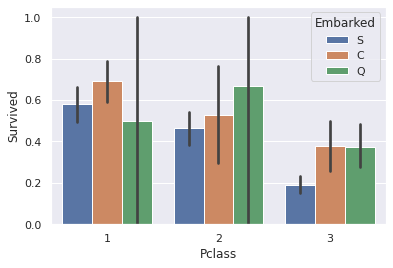

In [9]:
sns.barplot(x='Pclass', y='Survived', hue='Embarked', data=df_visualization)

<AxesSubplot:xlabel='Sex', ylabel='count'>

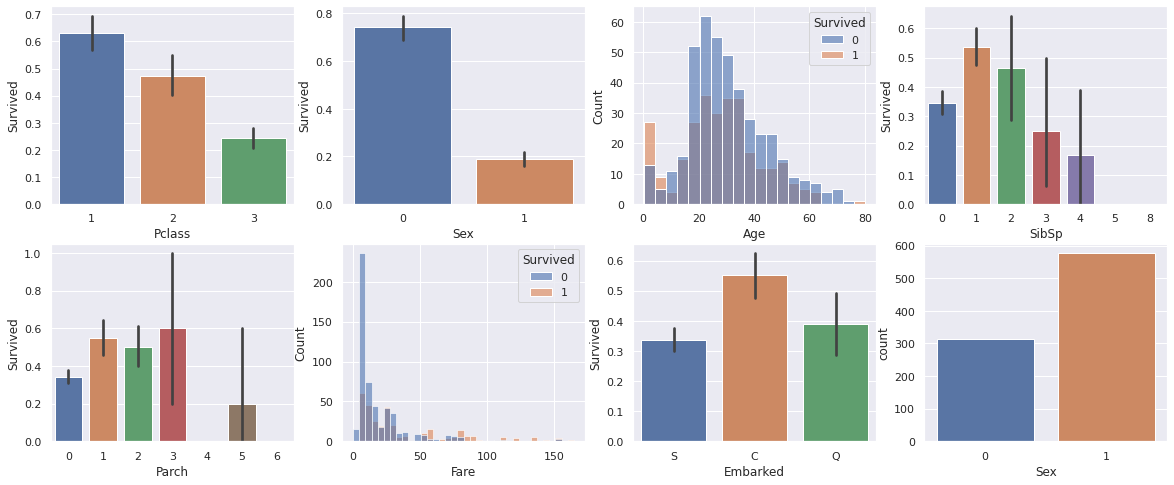

In [10]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8))

sns.barplot(data=df_visualization, x='Pclass', y='Survived', ax=axes[0,0])
sns.barplot(data=df_visualization, x='Sex', y='Survived', ax=axes[0, 1])
sns.histplot(data=df_visualization, x='Age', ax=axes[0, 2], hue='Survived', multiple='layer', alpha=0.6)
sns.barplot(data=df_visualization, x='SibSp', y='Survived', ax=axes[0, 3])
sns.barplot(data=df_visualization, x='Parch', y='Survived', ax=axes[1, 0])

fare_drop_cnt = 20
drop_indexes = np.argpartition(-df_visualization['Fare'], fare_drop_cnt)[:fare_drop_cnt]
sns.histplot(data=df_visualization.drop(drop_indexes, axis=0), x='Fare', ax=axes[1, 1], hue='Survived', multiple='layer', alpha=0.6)

sns.barplot(data=df_visualization, x='Embarked', y='Survived', ax=axes[1, 2])
sns.countplot(data=df_visualization, x='Sex',  ax=axes[1, 3])


let's try to say that for

plots below says:
1. nothing interesting to woman
2. mens with 1 SibSp have increased survivability, but with 0 have vary little survavability
3. we have a lot of womans compared to mans when SibSp=1

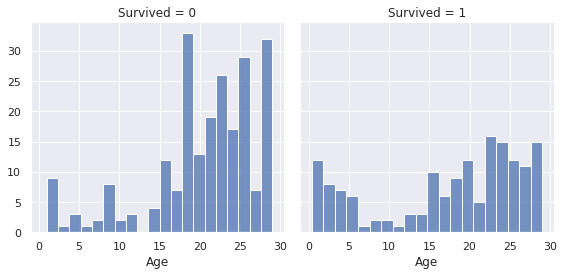

In [14]:
g = sns.FacetGrid(df_visualization[df_visualization['Age'] < 30], col='Survived', height=4)
g.map(sns.histplot, 'Age', bins=20)


<AxesSubplot:xlabel='Age', ylabel='Density'>

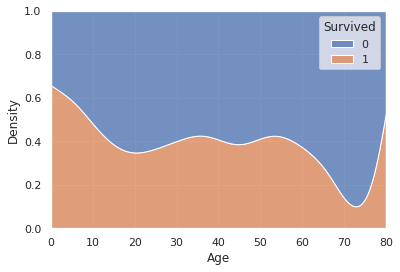

In [13]:
sns.kdeplot(
    data=df_visualization,
    x="Age", hue="Survived",
    multiple="fill", clip=(0, df_visualization['Age'].max())
)

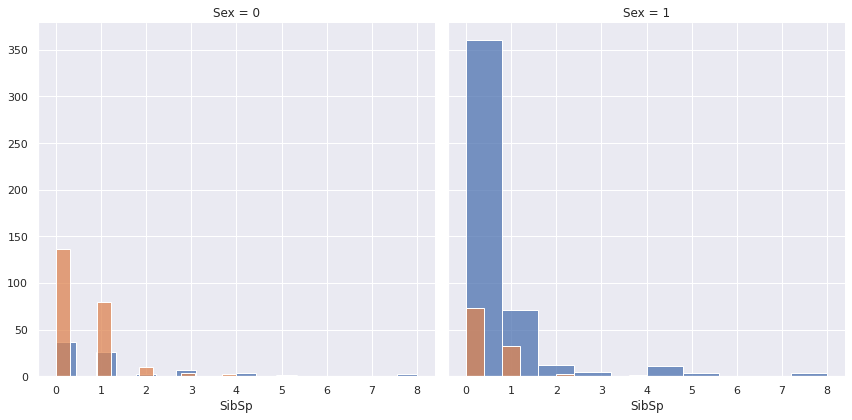

In [56]:
g = sns.FacetGrid(df_visualization, col='Sex', hue='Survived', height=6)
g.map(sns.histplot, 'SibSp')
plt.show()

plots below says:
1. nothing interesting to woman(again)
2. mens with 1 parch have increased survivability, but with 0 have very little survavability
3. we have a lot of mans compared to womans when Parch=0

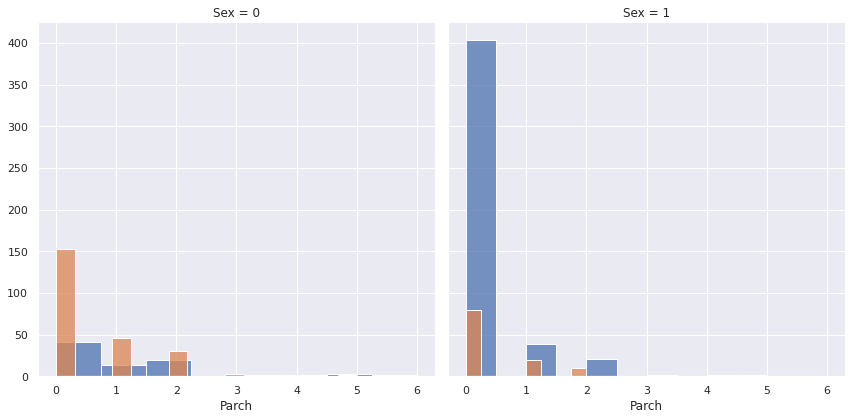

In [55]:
g = sns.FacetGrid(df_visualization, col='Sex', hue='Survived', height=6)
g.map(sns.histplot, 'Parch')

## Пробую подобрать хорошие параметры для логической регрессии в лоб(grid search)

Split data on training/test

In [126]:
df_X = df_cleaned.drop(labels='Survived', axis=1)
X = df_X.to_numpy()
y = df_cleaned['Survived'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)


In [127]:
model = Pipeline([('data_transformer', MinMaxScaler()), ('estimator', LogisticRegression())])
grid_parameters = [
    {
        'estimator__fit_intercept': [True, False],
        'estimator__C': [0.001, 0.01, 0.4, 1, 10, 100],
    }]
grid = GridSearchCV(model, grid_parameters, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('data_transformer', MinMaxScaler()),
                                       ('estimator', LogisticRegression())]),
             param_grid=[{'estimator__C': [0.001, 0.01, 0.4, 1, 10, 100],
                          'estimator__fit_intercept': [True, False]}])

In [128]:
grid.best_params_

{'estimator__C': 10, 'estimator__fit_intercept': True}

0.7794937456909288


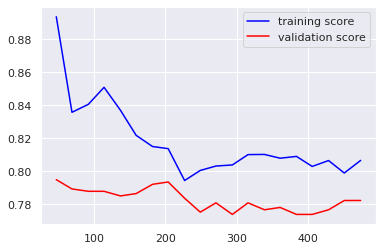

In [129]:
best_model = grid.best_estimator_
tools.plot_learning_curves(best_model, X, y)
print(cross_validate(grid.best_estimator_, X, y)['test_score'].mean())

 make sure that crossvalidate and plot learning curve work equvalently for trained and untrained model

0.7837190978036048


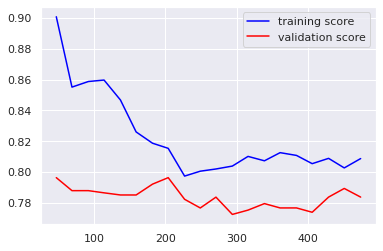

In [92]:
best_params = grid.best_params_
C = best_params['estimator__C']
fit_intercept = best_params['estimator__fit_intercept']
test = Pipeline([('data_transformer', MinMaxScaler()),
                 ('estimator', LogisticRegression(C=C, fit_intercept=fit_intercept))])
print(cross_validate(test, X, y)['test_score'].mean())
tools.plot_learning_curves(test, X, y)

Yeah, they work in the same way

## Эксперемнтирую с регулязацией

Так как методом тыка(грида) ничего не получилось сделать. Я решил посмотреть как меняются коэффициенты регрессии в зависимости от параметра регуляризации

In [134]:

def playing_with_penalty(C=1, penalty='l2'):
    X = df_cleaned.drop(labels=['Survived'], axis=1)
    y = df_cleaned['Survived']
    model = Pipeline([('data_transformer', MinMaxScaler()), ('estimator', LogisticRegression(penalty=penalty, C=C))])
    tools.plot_learning_curves(model, X, y)
    model.fit(X, y)
    return tools.get_coefs_of_regression(model['estimator'], df_X)

При маленькой регуляризации все парметры играют роль

Pclass       -2.398508
Age          -3.449790
SibSp        -1.816012
Parch        -0.361639
Fare          0.733461
Sex_female    2.053544
Sex_male     -0.584941
Embarked_C    0.897811
Embarked_Q    0.074209
Embarked_S    0.496582
intercept     1.468608
dtype: float64

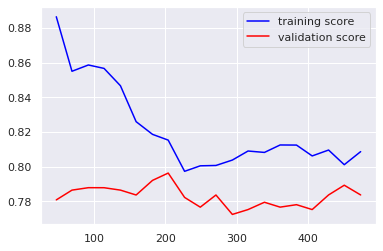

In [142]:
# small penalty
playing_with_penalty(C=1e6)

Pclass       -2.393811
Age          -3.430685
SibSp        -1.803842
Parch        -0.360502
Fare          0.725396
Sex_female    1.320790
Sex_male     -1.315619
Embarked_C    0.410035
Embarked_Q   -0.412723
Embarked_S    0.007858
intercept     2.678073
dtype: float64

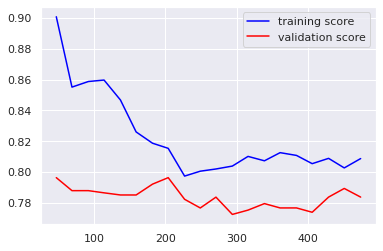

In [143]:
playing_with_penalty(C=1e2)

Pclass       -2.063324
Age          -2.259569
SibSp        -1.117715
Parch        -0.263937
Fare          0.423856
Sex_female    1.250759
Sex_male     -1.251334
Embarked_C    0.401858
Embarked_Q   -0.352032
Embarked_S   -0.050401
intercept     2.031381
dtype: float64

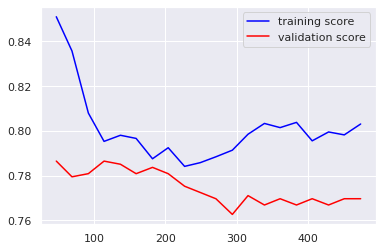

In [144]:
# bigger penalty
playing_with_penalty(C=1)

До сих пор большинство парметров важны

Pclass       -1.525622
Age          -0.947809
SibSp        -0.451387
Parch        -0.102234
Fare          0.255880
Sex_female    1.129621
Sex_male     -1.129637
Embarked_C    0.364831
Embarked_Q   -0.242163
Embarked_S   -0.122685
intercept     1.196317
dtype: float64

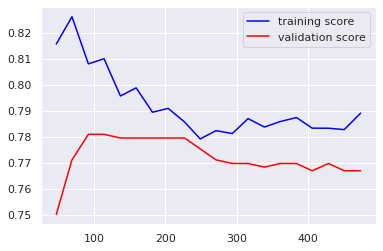

In [140]:
playing_with_penalty(C=0.2)

Теперь влияет в основном только пол

Pclass       -0.352486
Age          -0.052472
SibSp        -0.021975
Parch         0.019217
Fare          0.061180
Sex_female    0.489238
Sex_male     -0.489239
Embarked_C    0.143369
Embarked_Q   -0.032840
Embarked_S   -0.110530
intercept     0.020524
dtype: float64

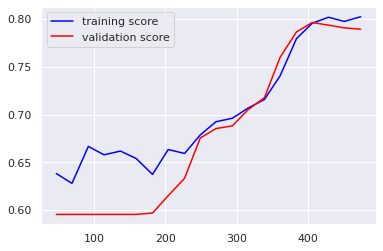

In [141]:
# really strong penalty
playing_with_penalty(C=0.01)

## Использую hot encoding, чтобы сделать логическую регрессию более сложной

### использую one hot encoding для SibSp, Parch, Age(поделен на 20 категорий)

In [100]:
df_one_hot = df_cleaned.copy()
df_one_hot['Age'] = pd.cut(df_one_hot['Age'], bins=20)
df_one_hot = pd.get_dummies(df_one_hot, columns=['SibSp', 'Parch', 'Age'])

Несмотря на данное усложненение модель ведет себя не сильно лучше

cross validation score 0.7951785714285714


Pclass                 -1.376435
Fare                    0.377125
Sex_female              1.233444
Sex_male               -1.233429
Embarked_C              0.513238
Embarked_Q             -0.230629
Embarked_S             -0.282594
SibSp_0                 0.219617
SibSp_1                 0.528626
SibSp_2                 0.241804
SibSp_3                -0.163641
SibSp_4                -0.270279
SibSp_5                -0.556112
Parch_0                 0.527250
Parch_1                 0.345542
Parch_2                 0.157300
Parch_3                 0.000000
Parch_4                -0.734344
Parch_5                -0.295733
Parch_6                 0.000000
Age_(0.34, 4.399]       1.526330
Age_(4.399, 8.378]      0.534748
Age_(8.378, 12.357]    -0.148300
Age_(12.357, 16.336]    0.181245
Age_(16.336, 20.315]    0.315804
Age_(20.315, 24.294]   -0.022866
Age_(24.294, 28.273]   -0.655619
Age_(28.273, 32.252]    0.162295
Age_(32.252, 36.231]    0.117065
Age_(36.231, 40.21]    -0.412752
Age_(40.21

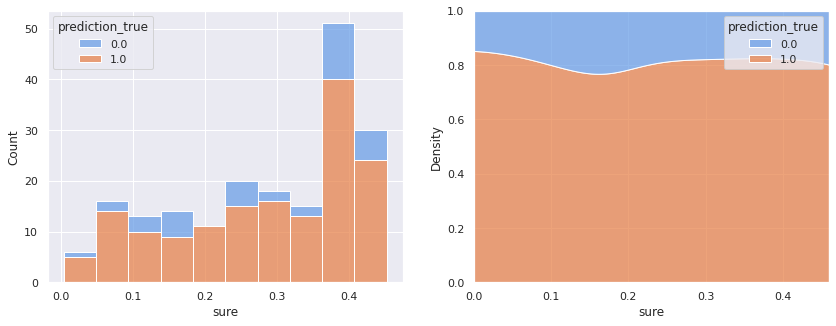

In [103]:
df = df_one_hot.drop(labels=['Survived'], axis=1)
y = df_one_hot['Survived']
model = Pipeline([('data_transformer', MinMaxScaler()), ('estimator', LogisticRegression(C=1, max_iter=1e3))])

validate_score = cross_validate(X=df,
                                y=df_one_hot['Survived'],
                                estimator=model, cv=100)
print(f"cross validation score {validate_score['test_score'].mean()}")
X_train, X_test, y_train, y_test = train_test_split(df, y, train_size=0.4)
model.fit(X_train, y_train)
tools.plot_model_accuracy_against_probability(model, X_test, y_test)
tools.get_coefs_of_regression(model['estimator'], df)

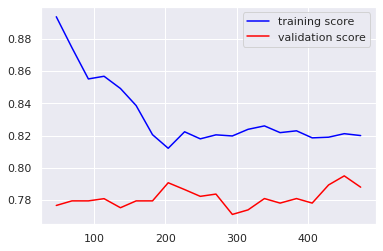

In [104]:
tools.plot_learning_curves(model, df, y)

### Попытаюсь избавиться от возраста

Опять же в данном случае избавление от возраста не позволяет нам избежать ситуации, в которой вероятность предсказания модели могла бы нам что-то говорить

cross validation score: 0.7780655963754556


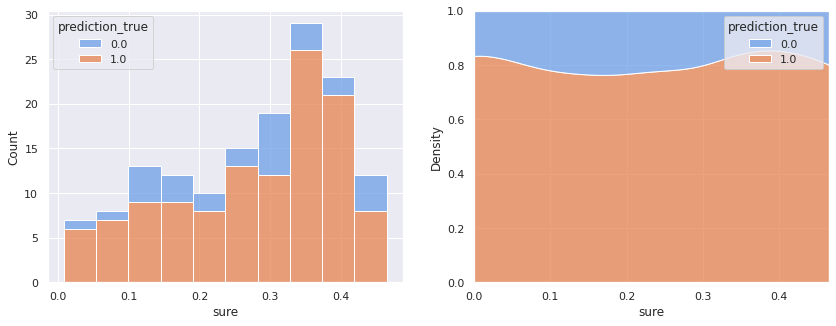

In [110]:
df = df_cleaned.drop(labels=['Survived'], axis=1)
df = pd.get_dummies(df, columns=['SibSp', 'Parch'])
y = df_cleaned['Survived']
model = Pipeline([('data_transformer', MinMaxScaler()), ('estimator', LogisticRegression(C=1, max_iter=1e3))])

validate_score = cross_validate(X=df,
                                y=y,
                                estimator=model, cv=5)
print('cross validation score:', validate_score['test_score'].mean())

X_train, X_test, y_train, y_test = train_test_split(df, y, train_size=0.5)
model.fit(X_train, y_train)
tools.plot_model_accuracy_against_probability(model, X_test, y_test)
plt.show()

## SVC

### Первичные эксперименты

In [53]:
from sklearn.svm import SVC

In [19]:
df_X = df_cleaned.drop(labels=['Survived'], axis=1)
X_train, X_test, y_train, y_test  = train_test_split(df_X,
                                                    df_cleaned['Survived'],
                                                    train_size=0.8)

In [20]:
def funning_with_svm(**kwargs):
    model = Pipeline([('data_transformer', MinMaxScaler()),
                      ('estimator', SVC(**kwargs))])
    tools.plot_learning_curves(model, df_X, df_cleaned['Survived'])
    print (cross_validate(model, X_train, y_train, cv=5)['test_score'].mean())

Yeah! this model can be complexity enough to overfit data. Maybe, I can find parameters to get just right

0.8031361589815246


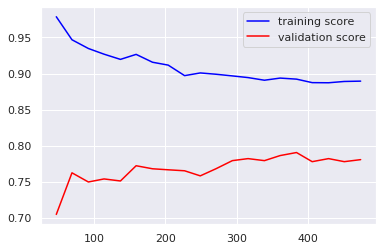

In [21]:
funning_with_svm(C=10, gamma=10 ,kernel='rbf')

Underfit the data

0.7785902810122651


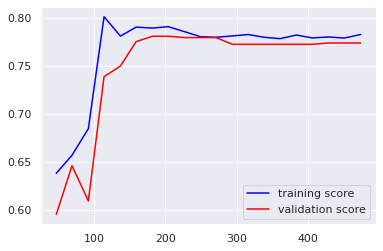

In [22]:
funning_with_svm(C=0.1, kernel='rbf')

В этом случае у нас переобучение. То есть SVM достаточно сложная

0.8031361589815246


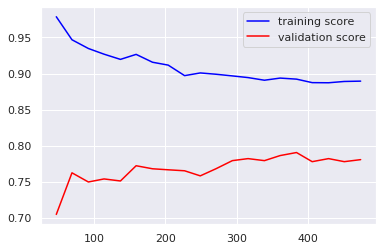

In [23]:
funning_with_svm(C=10, kernel='rbf', gamma=10)

In [148]:
def create_model(param_C, gamma):
    return Pipeline([('data_transformer', MinMaxScaler()),
                     ('estimator', SVC(C=param_C, gamma=gamma))])


### Смотрим на learning curve при различных гиперпараметрах

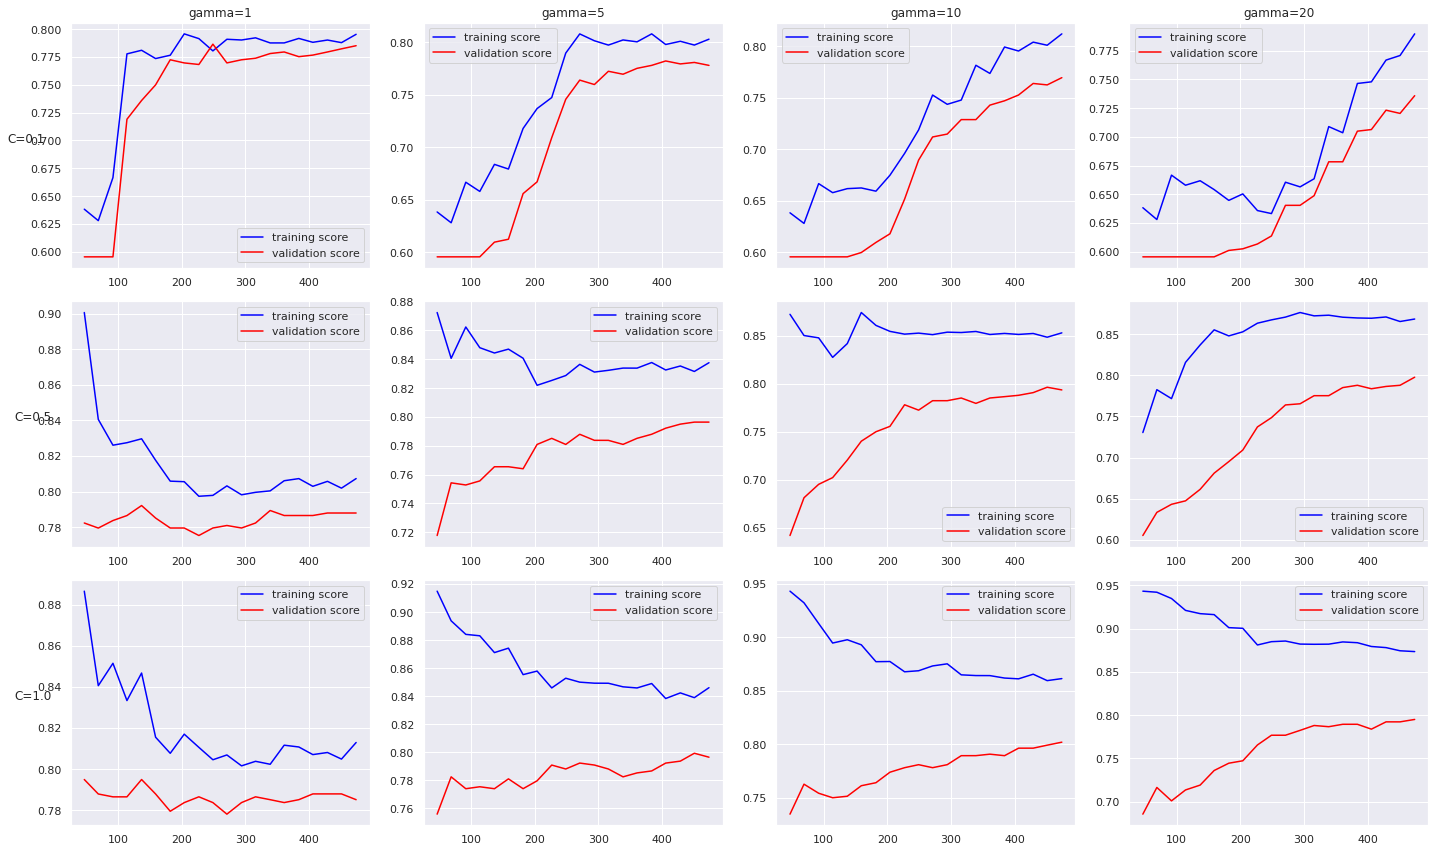

In [25]:
tools.grid_search_learning_curves(create_model, df_X, df_cleaned['Survived'], grid_param1=[0.1, 0.5, 1], grid_param2=[1, 5, 10, 20], param1_name='C', param2_name='gamma')

Мы можем здесь заметить переобучение, поэтому неплохо было бы добавить данных, заменив nan в Age на средний возраст

In [145]:
df = df_nans.copy()
df[df.isna()] = df['Age'].mean()
X, y = df.drop(labels='Survived', axis=1), df['Survived']


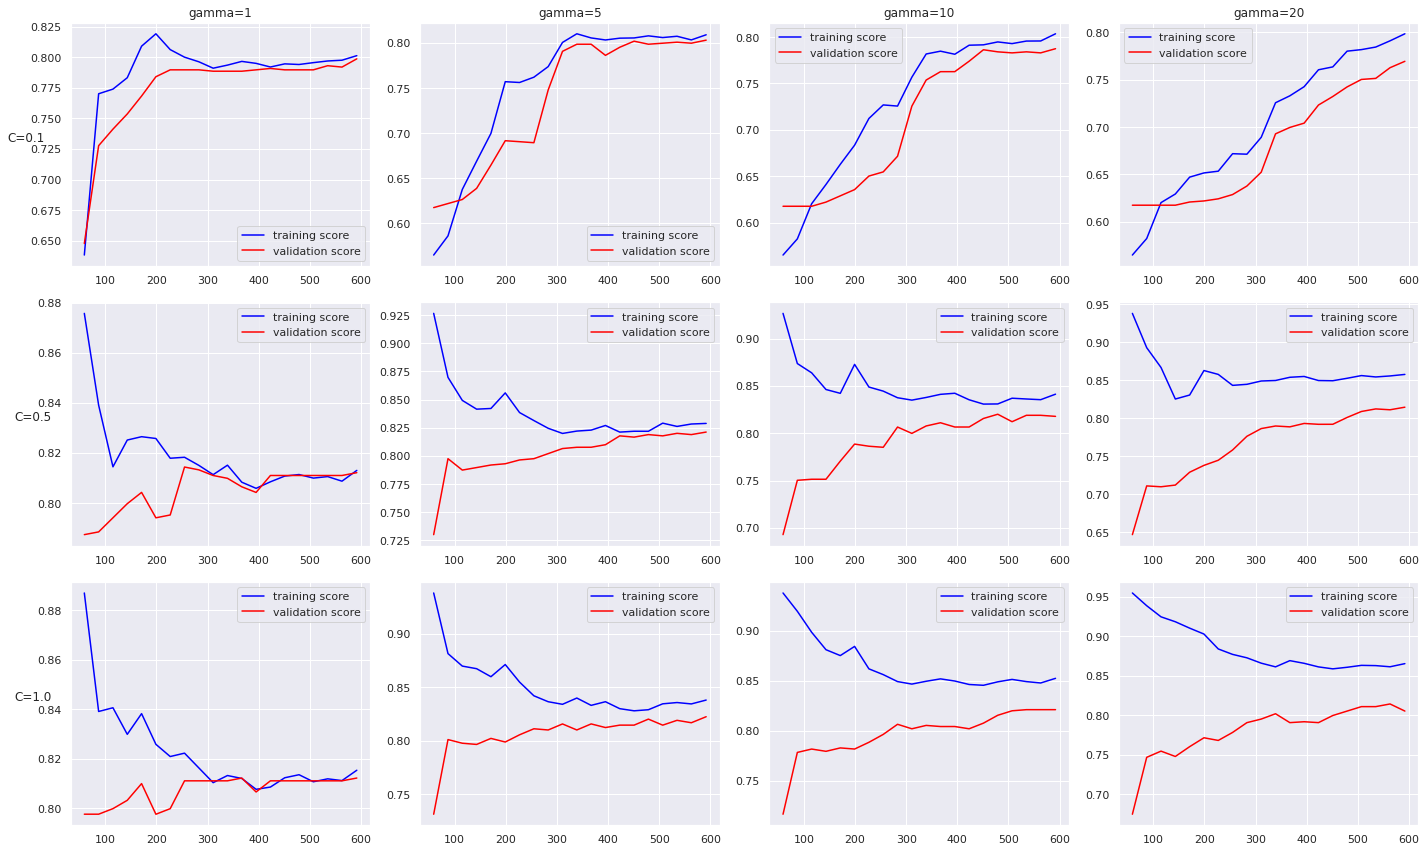

In [149]:
tools.grid_search_learning_curves(create_model, X, y, grid_param1=[0.1, 0.5, 1], grid_param2=[1, 5, 10, 20], param1_name='C', param2_name='gamma')

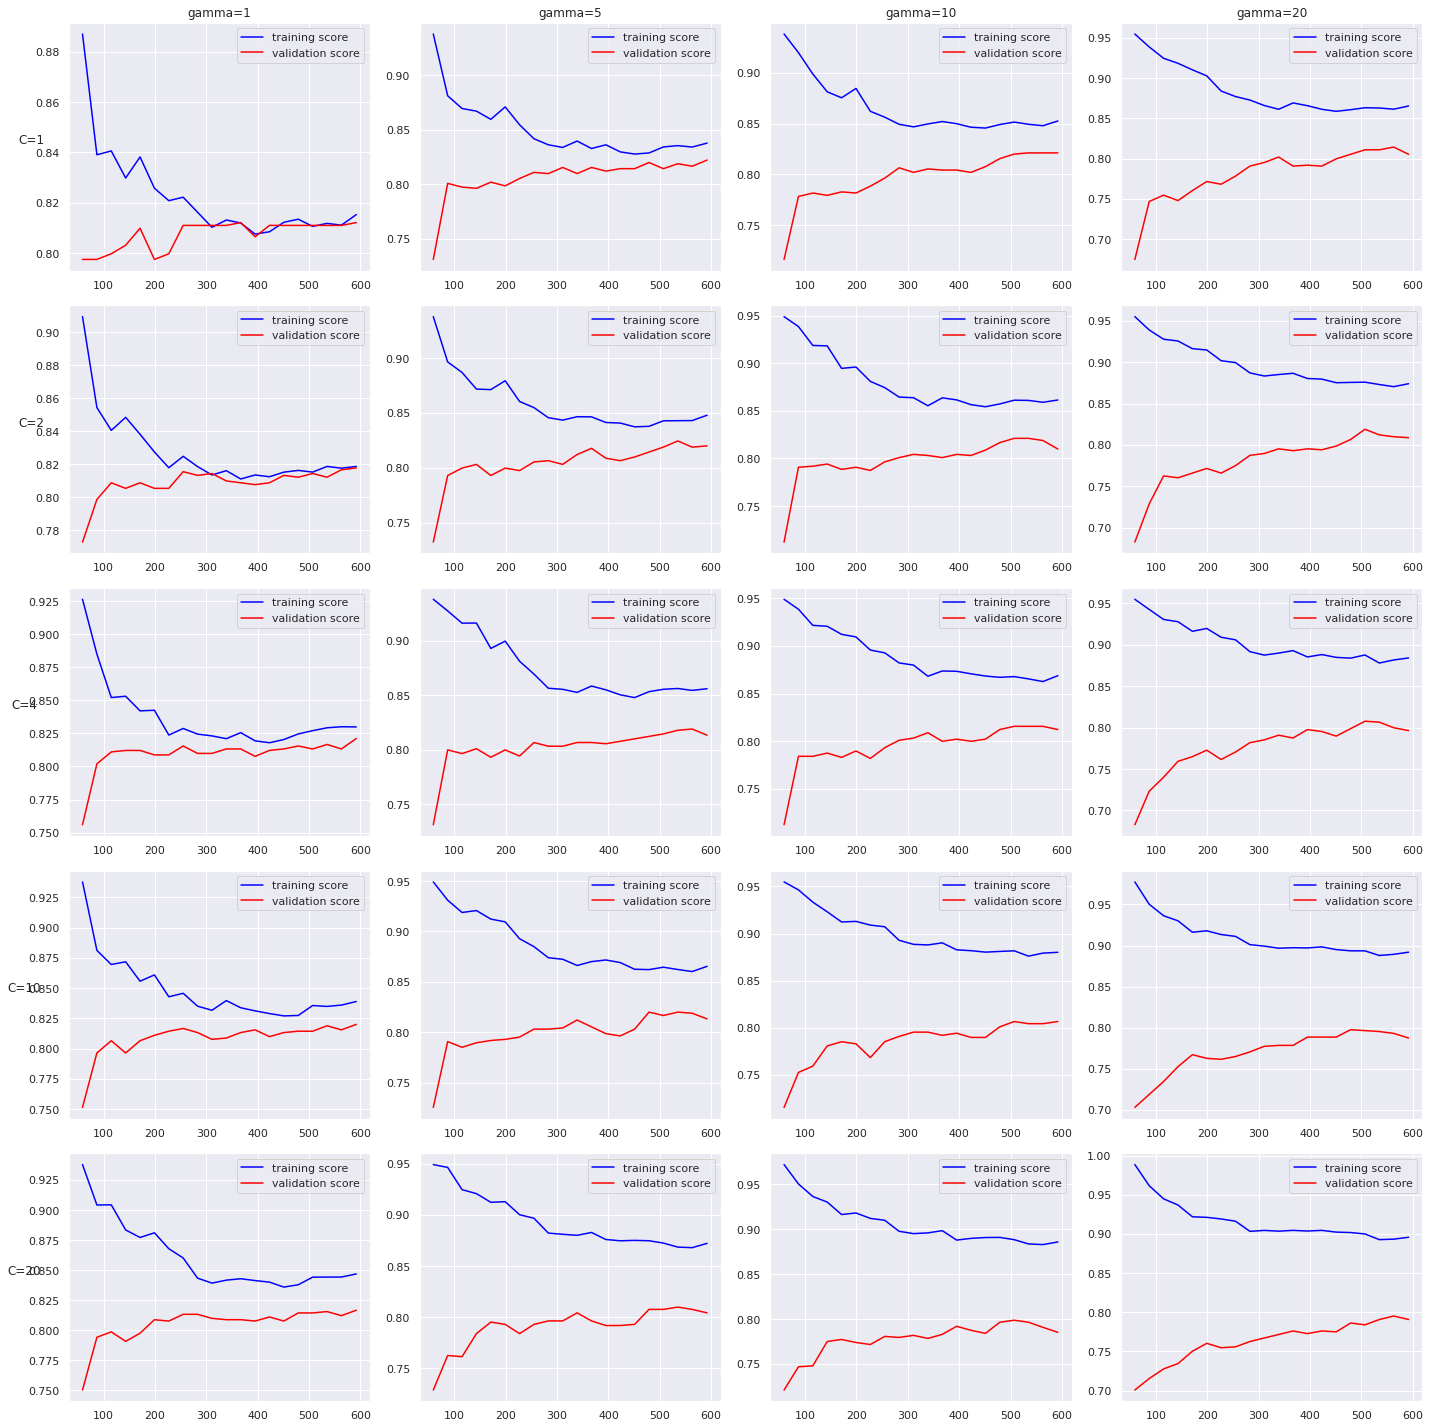

In [38]:
tools.grid_search_learning_curves(create_model, X, y, grid_param1=[1, 2, 4, 10, 20], grid_param2=[1, 5, 10, 20], param1_name='C', param2_name='gamma')

Слишком большие gamma слишком сильно переобучают модель. Попробую посмотреть уменьшенные gamma

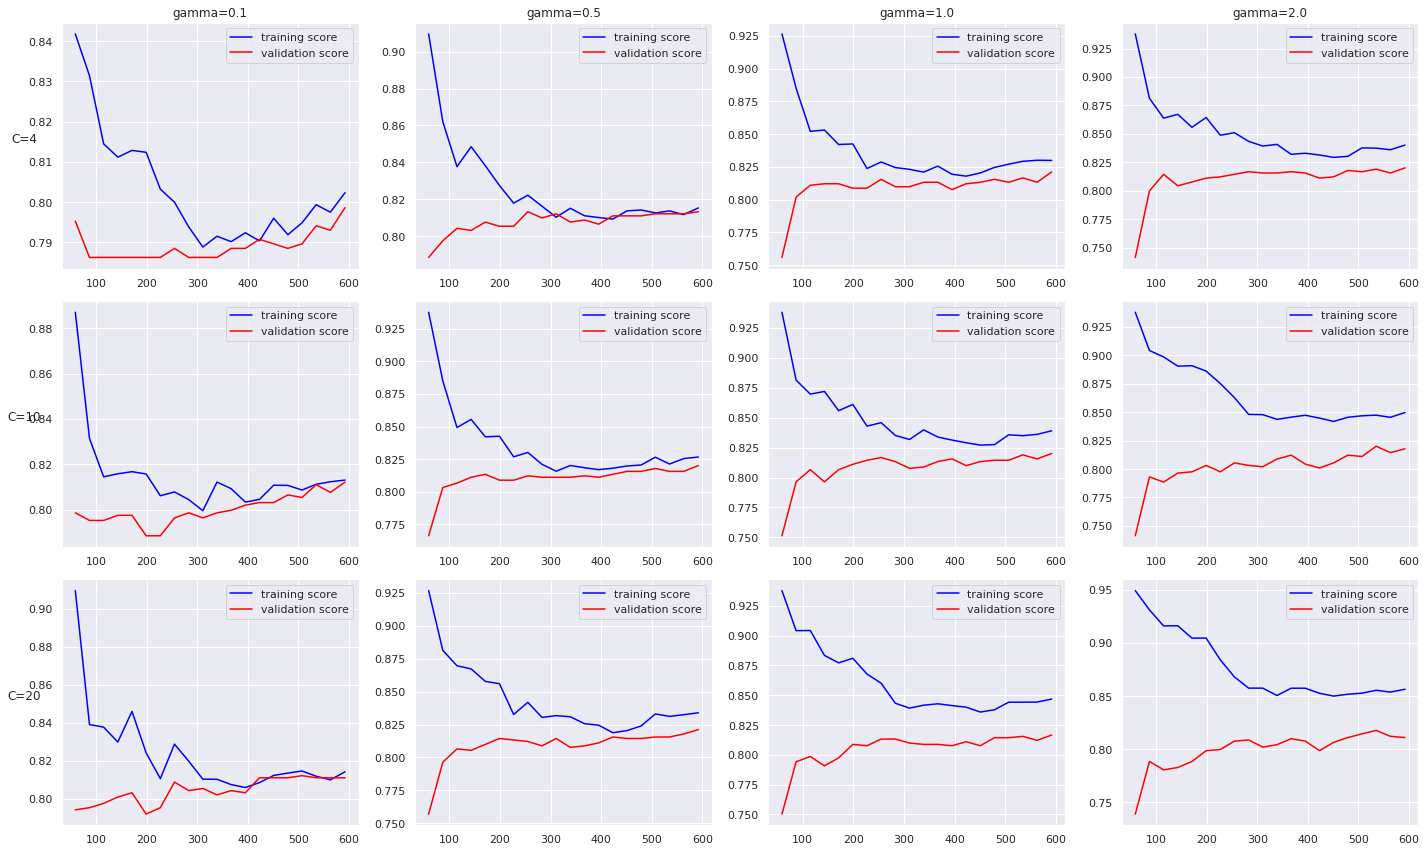

In [94]:
tools.grid_search_learning_curves(create_model, X, y, grid_param1=[4, 10, 20], grid_param2=[0.1, 0.5, 1], param1_name='C', param2_name='gamma')

let's try to apply really big grid search to find best model in range of model defined upper

In [13]:
model = Pipeline([('data_transformer', MinMaxScaler()),
                  ('estimator', SVC())])
grid_parameters = [{
    'estimator__C': [0.1, 1, 2, 4, 10, 20, 40],
    'estimator__gamma': [0.05, 0.1, 0.2, 0.5, 1, 10, 20, 40]
}]
grid = GridSearchCV(model, grid_parameters, cv=10)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('data_transformer', MinMaxScaler()),
                                       ('estimator', SVC())]),
             param_grid=[{'estimator__C': [0.1, 1, 2, 4, 10, 20, 40],
                          'estimator__gamma': [0.05, 0.1, 0.2, 0.5, 1, 10, 20,
                                               40]}])

In [14]:
grid.best_estimator_

Pipeline(steps=[('data_transformer', MinMaxScaler()),
                ('estimator', SVC(C=4, gamma=1))])

In [15]:
best = grid.best_estimator_
np.sum(best.predict(X_test) == y_test) / y_test.size

0.8321678321678322

let's test one of the model via really good crossavalidation

In [42]:
cross_validate(best, X, y, cv=50)['test_score'].mean()

0.8182352941176471

Yeah we have reached 82-83 percents of score

## PCA

In [7]:
from sklearn.decomposition import PCA

In [8]:
df =df_cleaned
X = df.drop('Survived', axis=1)
y = df['Survived']

In [9]:
components = PCA(n_components=3).fit_transform(X)

In [10]:
components

array([[-2.75248129e+01, -6.89782444e+00,  1.47445580e-03],
       [ 3.69463615e+01,  7.35098739e+00,  1.04704306e-01],
       [-2.67390711e+01, -2.90684637e+00, -4.14103405e-01],
       ...,
       [-4.84884394e+00, -1.04734573e+01, -8.69502853e-01],
       [-4.65521528e+00, -3.47133364e+00, -1.01023219e+00],
       [-2.67503335e+01,  3.10052831e+00, -5.17742666e-01]])

In [11]:
print(y.to_numpy()[:, np.newaxis].shape)
print(components.shape)

(712, 1)
(712, 3)


In [13]:
data = np.hstack([components, y.to_numpy()[:, np.newaxis]])
components_df = pd.DataFrame(data, columns=['x', 'y', 'z', 'hue'])

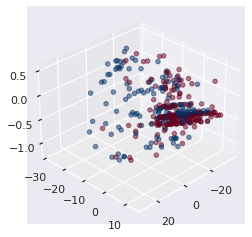

<Figure size 3000x3000 with 0 Axes>

In [78]:
ax = plt.axes(projection='3d')
fig = plt.figure(figsize=(20, 20), dpi=150)
components_copy = components.copy()
# convert to numpy for correct work of np.delete
y_copy = y.copy().to_numpy()
drop_cnt=100
for col in range(3):
    drop_indexes = np.argpartition(-components_copy[:, col], drop_cnt)[:drop_cnt]
    components_copy = np.delete(components_copy, drop_indexes, axis=0)
    y_copy = np.delete(y_copy, drop_indexes)
ax.scatter3D(components_copy[:, 0], components_copy[:, 1], components_copy[:, 2],
             c=y_copy, cmap='RdBu', alpha=0.5)
ax.view_init(30, 45)

Как видим, особых результатов это не дало

## Naive bayes

In [150]:
from sklearn import naive_bayes

In [32]:
from gaussian import predict, get_labels_statistic

In [42]:
X = df_cleaned.drop('Survived', axis=1)
y = df_cleaned['Survived']

In [47]:
model = naive_bayes.GaussianNB()
cross_validate(model, X, y)['test_score'].mean()

0.7697429331232148

In [41]:
stat =get_labels_statistic(X_train, y_train)
predicted = predict(X_test.to_numpy(), stat)
np.sum(y_test.to_numpy() == predicted) / y_test.size

0.7780898876404494

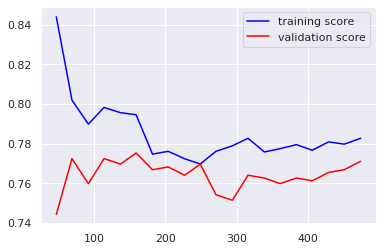

In [46]:
tools.plot_learning_curves(model, X, y)

In [52]:
def generate_model(model_name, placeholder):
    models = {'gaus': naive_bayes.GaussianNB(),
              'mult': naive_bayes.MultinomialNB,
              'comp': naive_bayes.ComplementNB,
              'cat': naive_bayes.CategoricalNB}
    return models['model_name']

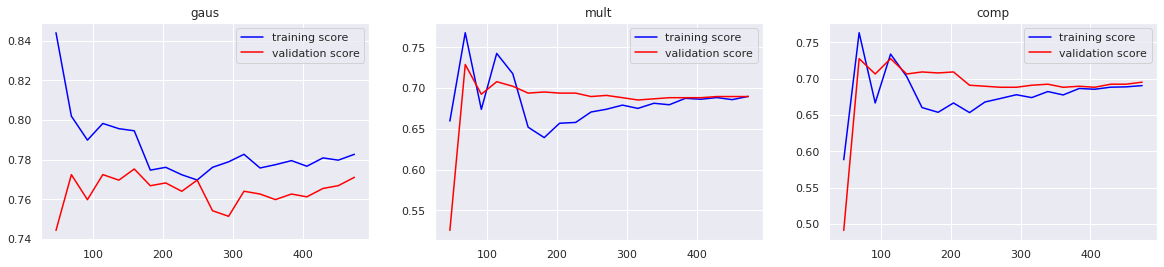

In [63]:
models = [['gaus', naive_bayes.GaussianNB()],
          ['mult', naive_bayes.MultinomialNB()],
          ['comp', naive_bayes.ComplementNB()]]
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
for ind, (name, model) in enumerate(models):
    axes[ind].set_title(name)
    tools.plot_learning_curves(model, X, y, ax=axes[ind])


## Тестирую гауссов наивный байес, который я сам написал

In [21]:
import gaussian

In [22]:
reload(gaussian)

<module 'gaussian' from '/home/vsevolod/Documents/python_stuff/kaggel-titanic-competition/gaussian.py'>

In [50]:
X = df_cleaned.drop(labels='Survived', axis=1).to_numpy()
y = df_cleaned['Survived'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [51]:
gaus_stat = gaussian.get_labels_statistic(X_train, y_train)

In [52]:
predicted = gaussian.predict(X_test, gaus_stat)
print(np.sum(predicted == y_test) / y_test.size)

0.7832167832167832


## Окончательный результат

Я решил использовать SVC с ярдром rbf

Подготавливаю данные

# TODO Моя подготовка данных ничего не делает с nan, а они есть в Name. Именно поэтому модель хуже предсказывает

In [ ]:
#todo

In [151]:
def prepare_df(df):
    df_for_model = df.drop(labels=['Ticket', 'Cabin', 'Name', 'PassengerId'], axis=1)
    df_for_model.dropna(inplace=True, subset=['Embarked'])
    df_for_model = pd.get_dummies(df_for_model, columns=['Sex', 'Embarked'])
    df_for_model[df_for_model.isna()] = df['Age'].mean()
    return df_for_model

In [152]:
df_train = pd.read_csv('data/train.csv')
df_to_predict = pd.read_csv('data/test.csv')

df_train_prepared = prepare_df(df_train)
X_train = df_train_prepared.drop(labels='Survived', axis=1)
y_train = df_train_prepared['Survived']

X_test = prepare_df(df_to_predict)

Подбираю и тренирую модель

In [153]:
model = Pipeline([('data_transformer', MinMaxScaler()),
                  ('estimator', SVC())])
grid_parameters = [{
    'estimator__C': [0.1, 1, 2, 4, 10, 20, 40],
    'estimator__gamma': [0.05, 0.1, 0.2, 0.5, 1, 10, 20, 40]
}]
grid = GridSearchCV(model, grid_parameters, cv=10)
grid.fit(X_train, y_train);

Создаю csv, чтобы залить на kaggle

In [156]:
cv = cross_validate(grid.best_estimator_, X_train, y_train, cv=20)
print('cv score mean', cv['test_score'].mean())

cv score mean 0.8278282828282828


In [157]:
predicted = grid.best_estimator_.predict(X_test)
passenger_ids = df_to_predict['PassengerId'].to_numpy()

In [158]:
kaggle_submit_df = pd.DataFrame({'PassengerId': passenger_ids,
                                 'Survived': predicted})
kaggle_submit_df.to_csv(path_or_buf='data/result_for_kaggle.csv', index=False)